#Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [131]:
df1 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/EMA Electricity Forecast/Electricity-Generated (monthly).xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_Enabled
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_SetDate
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_Method
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_Name
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_SiteId
  warn(f"Unknown type for {prop.name}")
/usr/

In [132]:
df1

,Month,Electricity Generated (Gwh)
0,1975-01-01,341.8
1,1975-02-01,289.6
2,1975-03-01,342.8
3,1975-04-01,348.6
4,1975-05-01,351.4
...,...,...
581,2023-06-01,4797.3
582,2023-07-01,4931.7
583,2023-08-01,4945.2
584,2023-09-01,4780.2


In [6]:
df1.dtypes

Month                          datetime64[ns]
Electricity Generated (Gwh)           float64
dtype: object

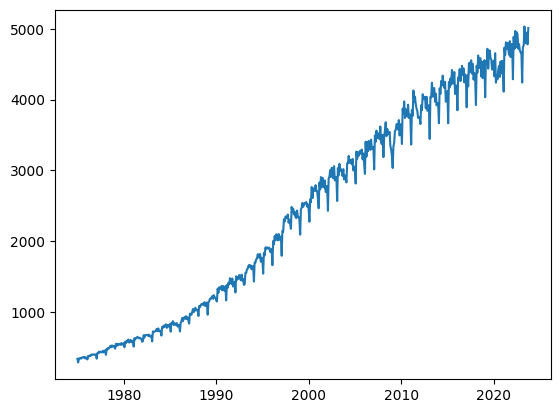

In [7]:
X= df1['Month']
y= df1['Electricity Generated (Gwh)']
plt.plot(X,y)

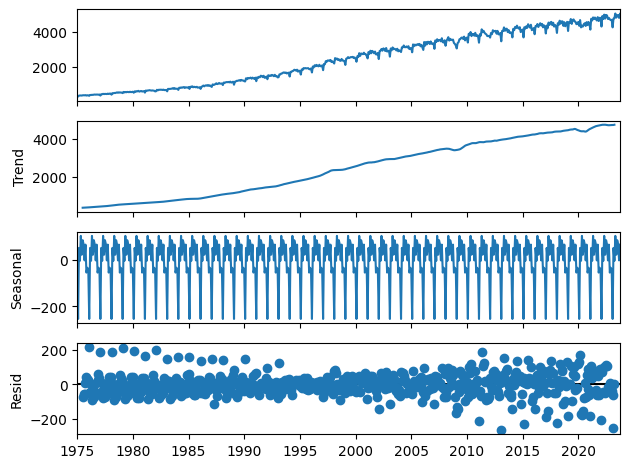

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df1.dropna(), model='additive')
decomposition.plot()
plt.show()

Step 1: Ensure Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

adfuller(y)[1]  # p-value

0.9843865318090247

In [14]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [17]:
adfuller_test(y)

ADF Test Statistic : 0.48425279813238736
p-value : 0.9843865318090247
#Lags Used : 14
Number of Observations : 571
weak evidence against null hypothesis,indicating it is non-stationary 


**since p-value > 0.05,  null hypothesis of the ADF test (the time series is non-stationary) cannot be rejected at any reasonable significance level. This suggests that the time series is non-stationary and may require differencing to make it stationary before fitting an ARIMA model.**

##Step 1 - Select d

Text(0.5, 1.0, 'third difference')

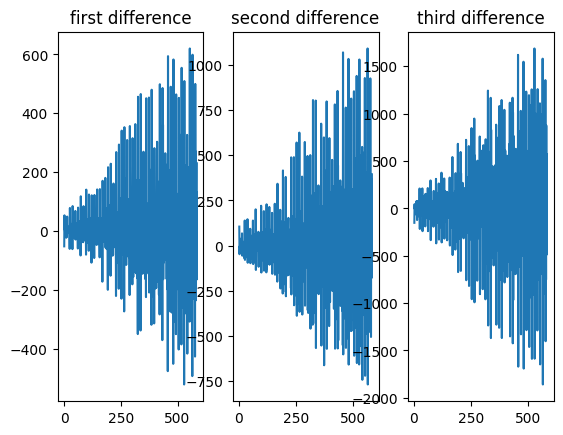

In [112]:
plt.subplot(1,3,1)
# non_differenced_data = pd.Series(y)
yd1 = y.diff().dropna()
yd1.plot();
plt.title('first difference')

plt.subplot(1,3,2)
yd2 = yd1.diff().dropna()
yd2.plot()
plt.title('second difference')

plt.subplot(1,3,3)
yd3 = yd2.diff().dropna()
yd3.plot()
plt.title('third difference')

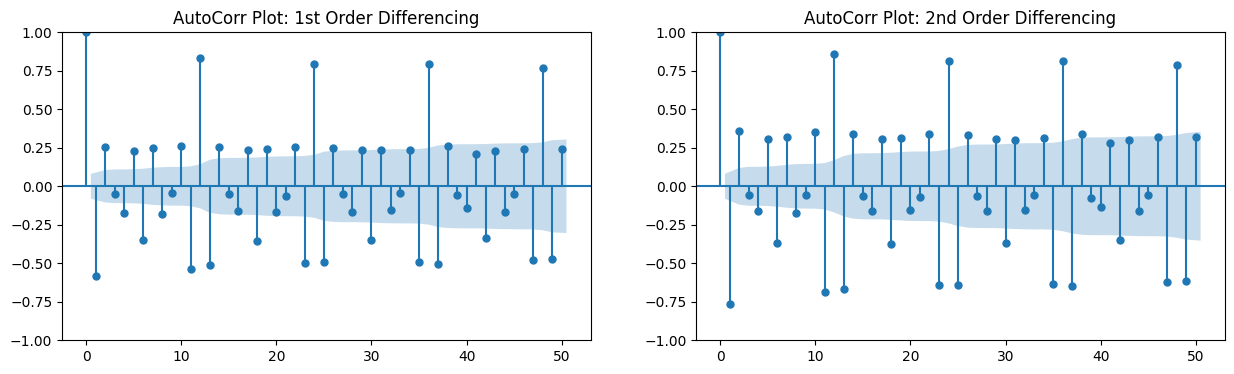

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2,figsize=(15,4))


plot_acf(yd1, lags=50, ax=axes[0]);
axes[0].set_title('AutoCorr Plot: 1st Order Differencing');


plot_acf(yd2, lags=50, ax=axes[1]);
axes[1].set_title('AutoCorr Plot: 2nd Order Differencing');

**since there is no significant difference, d=1 is taken**

##Step 2 - Select AR order(p) and MA order(q)

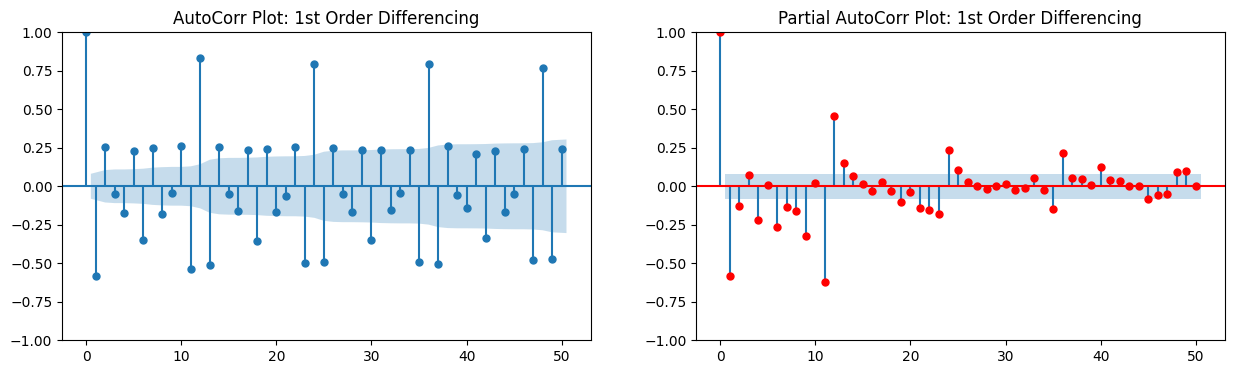

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(15,4))

# ACF / PACF analysis of y_diff linearized
plot_acf(yd1, lags=50, ax=axes[0]);
axes[0].set_title('AutoCorr Plot: 1st Order Differencing');

plot_pacf(yd1, lags=50, ax=axes[1], c='r');
axes[1].set_title('Partial AutoCorr Plot: 1st Order Differencing');

**from preliminary analysis, q=2, p=2**

##Step 3 - Build Model

In [ ]:
p=2;
d=1;
q=2;

from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

arima = ARIMA(y, order=(p,d,q))
arima = arima.fit()
arima.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Electricity Generated (Gwh)   No. Observations:                  586
Model:                          ARIMA(2, 1, 2)   Log Likelihood               -3583.154
Date:                         Wed, 28 Feb 2024   AIC                           7176.308
Time:                                 07:55:41   BIC                           7198.166
Sample:                                      0   HQIC                          7184.826
                                         - 586                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7314      0.001  -2074.097      0.000      -1.733      -1.730
ar.L2         -1.0000   1.56e-05  -6.39e+04      0.000      -1.000      -1.000
ma.L1          1.7092      0.037     45.634      0.000       1.636       1.783
ma.L2          1.0000      0.044     22.780      0.000       0.914       1.086
sigma2      1.205e+04    6.3e-06   1.91e+09      0.000    1.21e+04    1.21e+04
===================================================================================
Ljung-Box (L1) (Q):                  48.33   Jarque-Bera (JB):               198.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.80   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.78e+23. Standard errors may be unstable.
"""

In [85]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00


Optimizing p,d,q
stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC

In [86]:
import pmdarima as pm

base_model = pm.auto_arima(y, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(base_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7301.074, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7551.974, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7307.696, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7309.888, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7551.557, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7284.033, Time=1.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7299.906, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7283.252, Time=1.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7298.795, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7237.341, Time=3.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7232.503, Time=4.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7237.433, Time=3.50 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=3.98 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] interc

**Based on optimization, the best combination of the ARIMA model is: p=3, d=1, q=3**

In [21]:
p=3;
d=1;
q=3;

from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

arima_base = ARIMA(y, order=(p,d,q))
arima_base = arima_base.fit()
print(arima_base.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:     Electricity Generated (Gwh)   No. Observations:                  586
Model:                          ARIMA(3, 1, 3)   Log Likelihood               -3548.877
Date:                         Thu, 29 Feb 2024   AIC                           7111.753
Time:                                 01:35:43   BIC                           7142.355
Sample:                                      0   HQIC                          7123.679
                                         - 586                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2514      0.073    -17.083      0.000      -1.395      -1.108
ar.L2         -0.1703      0.128     -1.335      0.182     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Step 4a - Forecast (dynamic=false, base)
☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

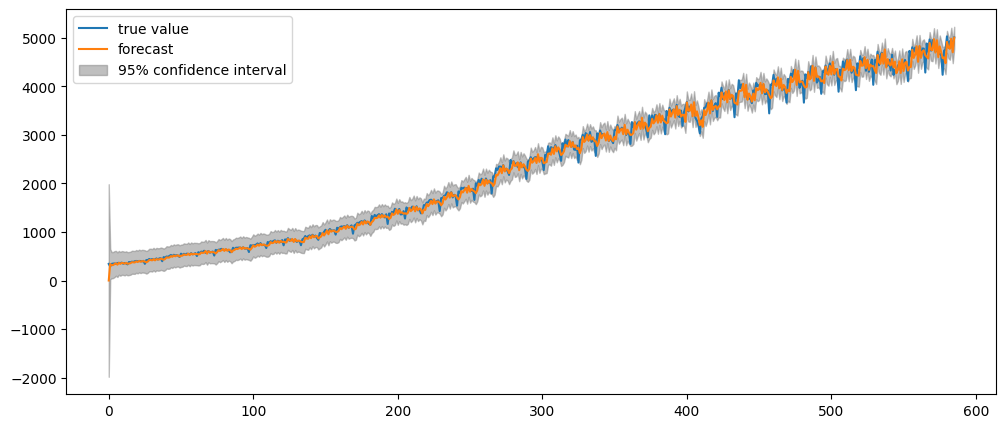

In [38]:
from statsmodels.graphics.tsaplots import plot_predict
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y, label='true value')
plot_predict(arima_base, start=0, ax=axs, dynamic=False);

###Forecast for the next 12 months after Sep 2023 (=point #585)

In [23]:
forecast_base = arima_base.forecast(steps=12)
forecast_base

586    4764.306334
587    4892.239368
588    4879.590278
589    4756.205154
590    4973.857131
591    4716.460764
592    4942.575922
593    4807.391578
594    4815.132893
595    4936.449007
596    4718.758997
597    4974.211548
Name: predicted_mean, dtype: float64

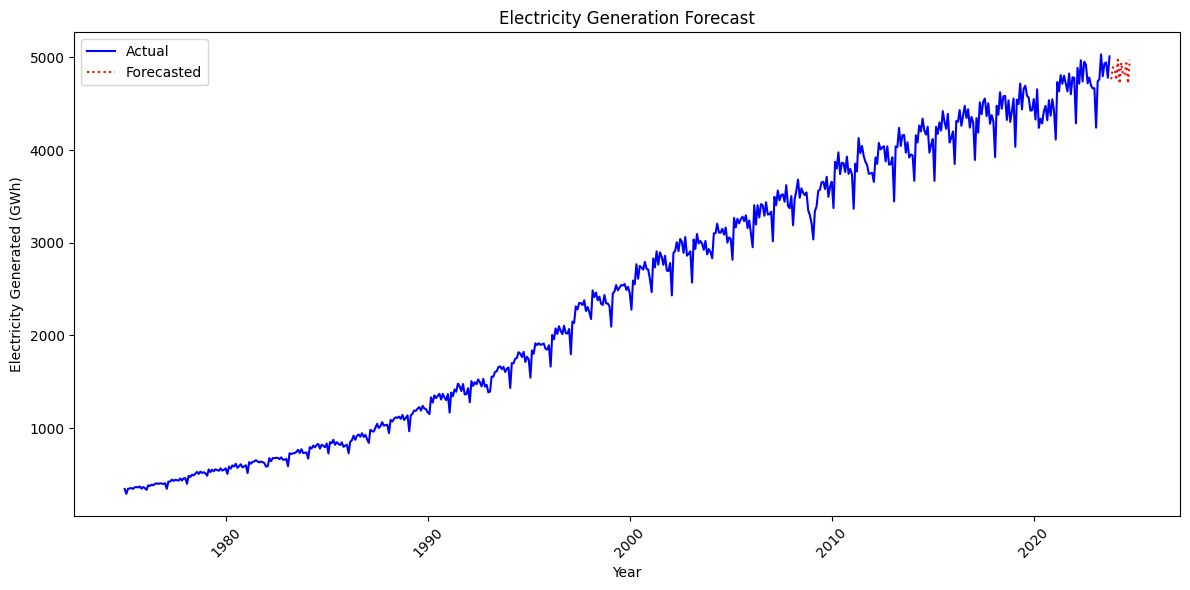

In [24]:
# Creating a dataframe for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS') #'M': start of month, 'MS': end of month
forecast_base_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_base.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')

plt.plot(forecast_base_df['Month'], forecast_base_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='dotted')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()





Zoom in (last 50 points)

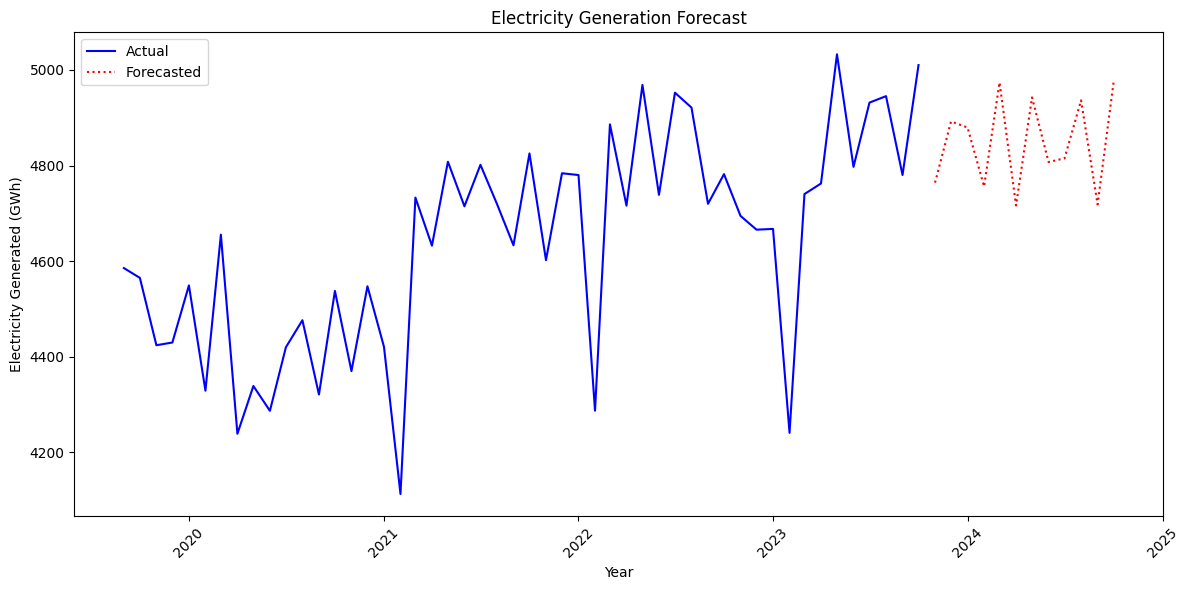

In [26]:
# Creating a dataframe for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS') #'M': start of month, 'MS': end of month
forecast_base_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_base.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
#plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(df1['Month'].iloc[-50:], df1['Electricity Generated (Gwh)'].iloc[-50:], label='Actual', color='blue')

plt.plot(forecast_base_df['Month'], forecast_base_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='dotted')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [27]:
forecast_base_df

,Month,Forecasted Electricity Generated (Gwh)
0,2023-11-01,4764.306334
1,2023-12-01,4892.239368
2,2024-01-01,4879.590278
3,2024-02-01,4756.205154
4,2024-03-01,4973.857131
5,2024-04-01,4716.460764
6,2024-05-01,4942.575922
7,2024-06-01,4807.391578
8,2024-07-01,4815.132893
9,2024-08-01,4936.449007


## Step 4b - Forecast (dynamic=true)
👉 `dynamic=True` to plot a prediction of the _last 86 values_ in a situation where the model only has _access to data up to 500 (index 499)_. That is to say, the model:
- predicts 501 (index 500) based on true [1...500]
- then predicts 502 (index 501) based on [1...500] _plus_ its previously predicted value for 501 (index 500)
- etc...iteratively until 586 (index 585)

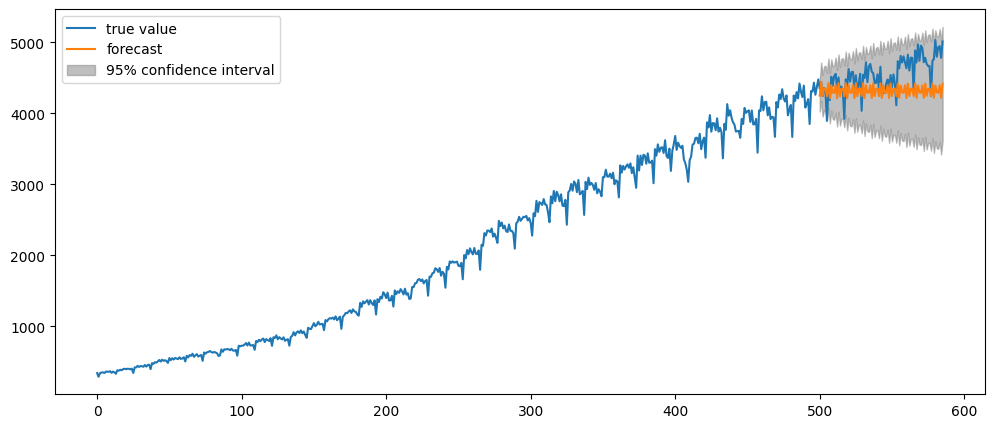

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y, label='true value')
plot_predict(arima_base, start=500, end=585, ax=axs, dynamic=True);

##Step 4c - Out-of-Time cross-validation Forecast (train-test-split)
👉 train size=500, test size=86

In [42]:
y_train = y[:500]
y_test = y[500:]

In [ ]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6109.571, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6299.275, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6111.320, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6123.707, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6299.214, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6097.019, Time=0.98 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6108.633, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6094.815, Time=0.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6105.992, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6099.440, Time=0.37 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 6.340 seconds
                               SARIMAX Results                                
Dep. Variable:     

***optimum parameters: p=3, d=1, q=1***

In [43]:
arima = ARIMA(y_train, order=(3, 1, 1), trend='t').fit()

In [44]:
# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(y_test), alpha=0.05) #95%cf
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [45]:
forecast

500    4384.904119
501    4483.682128
502    4431.900839
503    4468.348905
504    4473.691556
          ...     
581    5103.577380
582    5111.805751
583    5120.034122
584    5128.262493
585    5136.490863
Name: predicted_mean, Length: 86, dtype: float64

In [46]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(y_train, label='training', color='black')
    plt.plot(y_test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [47]:
print(forecast.shape)
print(y_train.shape)
print(y_test.shape)
print(confidence_int.shape)

(86,)
(500,)
(86,)
(86, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


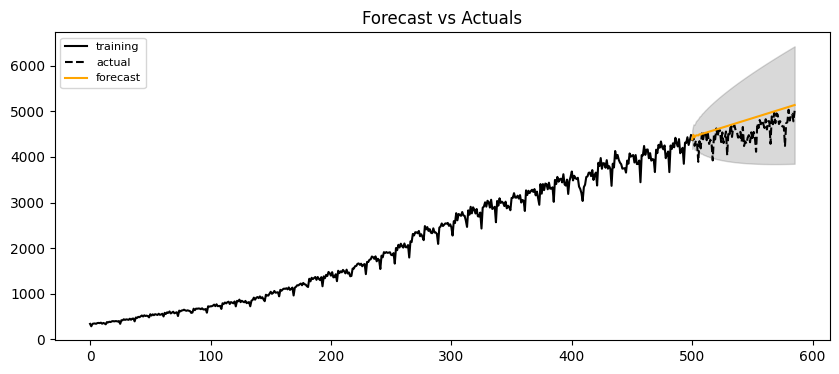

In [48]:
# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(y_test), alpha=0.05) #95%cf
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
plot_forecast(forecast, y_train, y_test, confidence_int[:,0], confidence_int[:,1])

***model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. ***

###Forecast for the next 12 months after 01 Oct 2023 (index 585)

In [200]:
# Forecast values and confidence intervals
forecast_results_12m = arima.get_forecast(steps=98, alpha=0.05) #last 86 rows (test size) + 12 months after Oct 2023
forecast_12m = forecast_results_12m.predicted_mean
confidence_int_12m = forecast_results_12m.conf_int().values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [201]:
forecast_12m

500    4384.904119
501    4483.682128
502    4431.900839
503    4468.348905
504    4473.691556
          ...     
593    5202.317830
594    5210.546200
595    5218.774571
596    5227.002942
597    5235.231313
Name: predicted_mean, Length: 98, dtype: float64

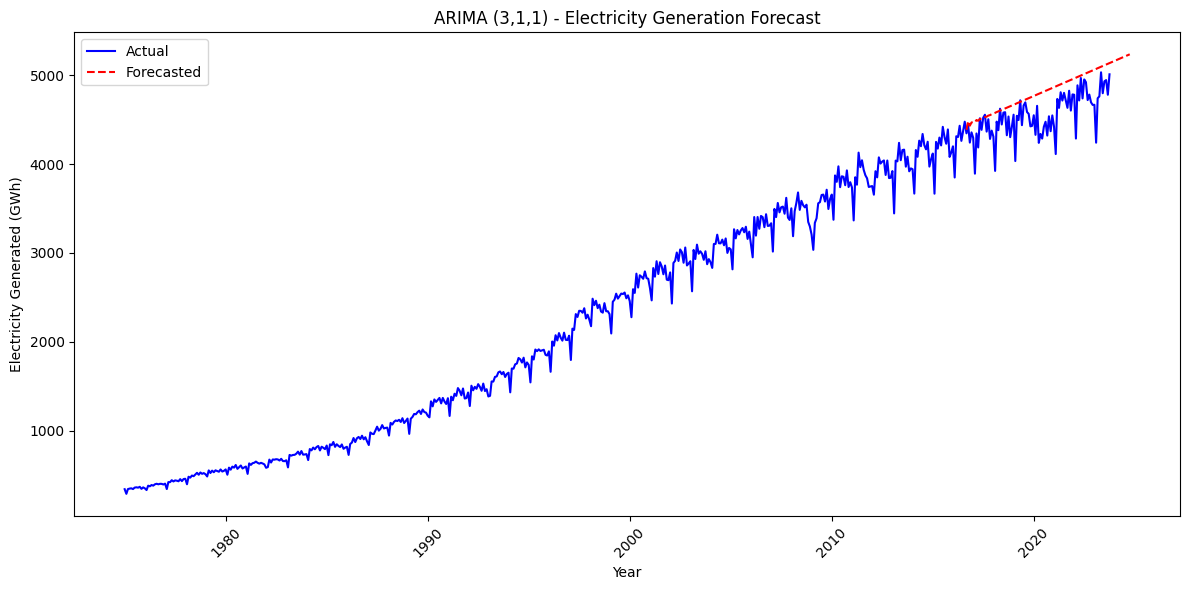

In [202]:
# Creating a DataFrame for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-87] + pd.offsets.MonthBegin(1), periods=len(forecast_12m), freq='MS') #'M': start of month, 'MS': end of month
forecast_12m_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_12m.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(forecast_12m_df['Month'], forecast_12m_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='--')
plt.title('ARIMA (3,1,1) - Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


In [204]:
forecast_12m_df

,Month,Forecasted Electricity Generated (Gwh)
0,2016-09-01,4384.904119
1,2016-10-01,4483.682128
2,2016-11-01,4431.900839
3,2016-12-01,4468.348905
4,2017-01-01,4473.691556
...,...,...
93,2024-06-01,5202.317830
94,2024-07-01,5210.546200
95,2024-08-01,5218.774571
96,2024-09-01,5227.002942


In [203]:
forecast_12m_df.tail(12)

,Month,Forecasted Electricity Generated (Gwh)
86,2023-11-01,5144.719234
87,2023-12-01,5152.947605
88,2024-01-01,5161.175976
89,2024-02-01,5169.404346
90,2024-03-01,5177.632717
91,2024-04-01,5185.861088
92,2024-05-01,5194.089459
93,2024-06-01,5202.317830
94,2024-07-01,5210.546200
95,2024-08-01,5218.774571


##Zoomed in (from 01 Sep 2016 onwards, inclusive)

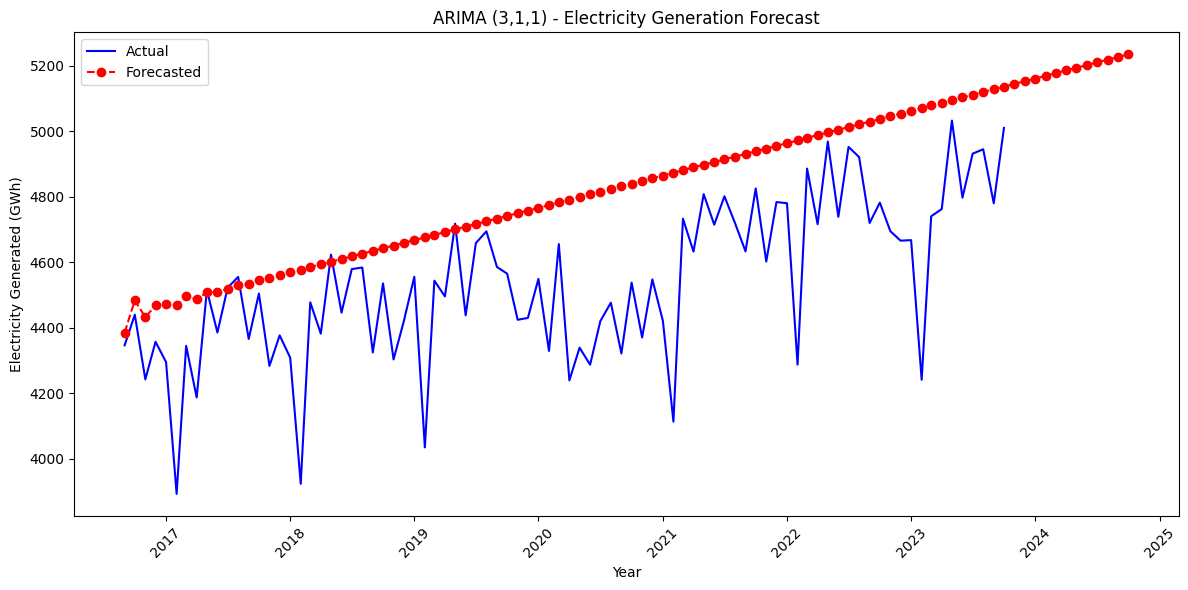

In [199]:
# Creating a DataFrame for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-87] + pd.offsets.MonthBegin(1), periods=len(forecast_12m), freq='MS')
forecast_12m_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_12m.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
#plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(df1['Month'].iloc[-86:], df1['Electricity Generated (Gwh)'].iloc[-86:], label='Actual', color='blue')
plt.plot(forecast_12m_df['Month'], forecast_12m_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='--', marker='o')
plt.title('ARIMA (3,1,1) - Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()




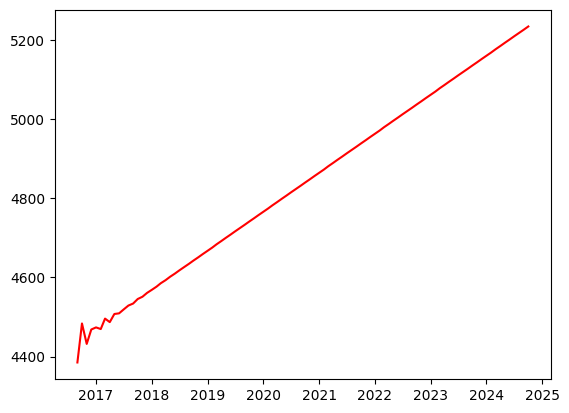

In [206]:
plt.plot(forecast_12m_df['Month'], forecast_12m_df['Forecasted Electricity Generated (Gwh)'], color='red')

## Step 5 - Check residuals

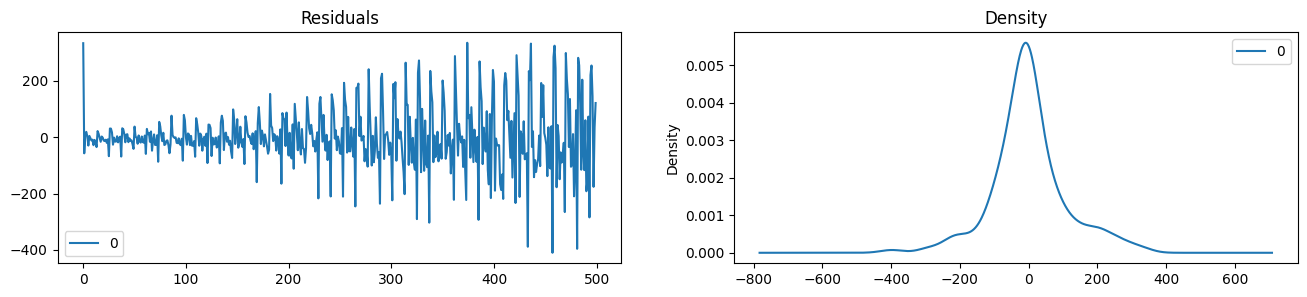

In [207]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

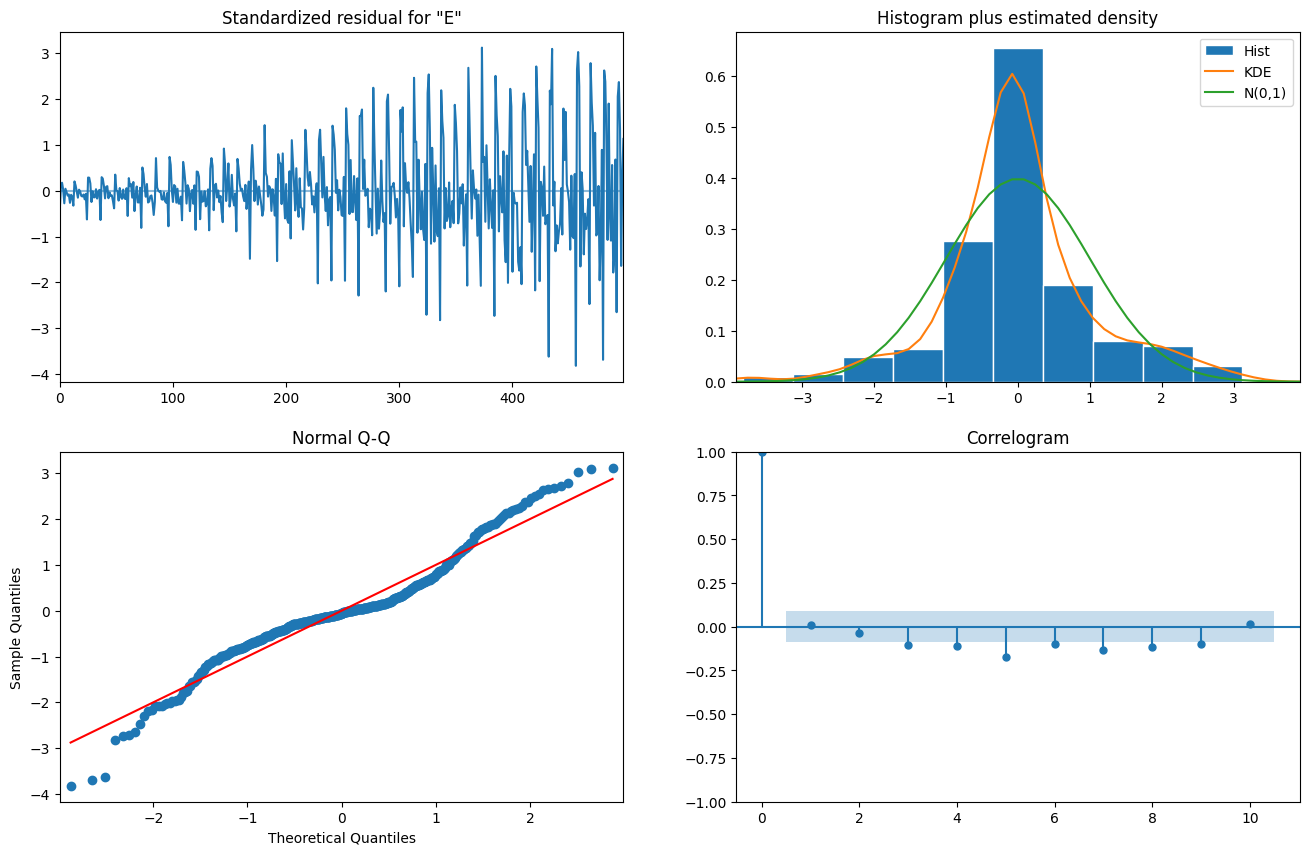

In [208]:
arima.plot_diagnostics(figsize=(16,10))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model

## Step 6 -Cross Validation of Performance Metrics

In [211]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [212]:
forecast_accuracy(forecast, y_test)

{'mape': 0.05578931681785842,
 'me': 245.2898833187051,
 'mae': 247.03027712077068,
 'mpe': 0.05541142969249884,
 'rmse': 306.137931539102,
 'acf1': 0.1508008936052815,
 'corr': 0.6696120033246564,
 'minmax': 0.051306995450812076}

**5.5% MAPE implies the model is about 94.5% accurate in predicting the next  86 observations.**

## Step 7 - Cross validation using TimeSeriesSplit + GridSearch

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


range_p = [0, 1, 2]
range_d = [1, 2]
range_q = [0, 1, 2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
y = y.astype('float32')

for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)

    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]

        # Using SARIMAX without seasonality or exogenous variables is equivalent to using ARIMA
        # SARIMAX's fit method comes with a maxiter keyword, useful to avoid warnings
        model = SARIMAX(y_train, order=order).fit(maxiter=75, disp=False)
        # model = ARIMA(y_train, order=order).fit()
        y_pred = model.forecast(len(y_test))

        r2s.append(r2_score(y_test, y_pred))
        orders.append(order)
        aics.append(model.aic)


df = pd.DataFrame(list(zip(fold_idxs, orders, aics, r2s)), columns =['Fold', '(p, d, q)', 'AIC', 'R2'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

In [ ]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

(p, d, q)
(2, 1, 2)    3318.797502
(1, 2, 2)    3334.408367
(2, 2, 2)    3334.599935
(2, 2, 1)    3336.583696
(1, 2, 1)    3338.510805
(0, 2, 2)    3339.041198
(2, 1, 1)    3343.974782
(2, 1, 0)    3347.141343
(1, 1, 1)    3347.444235
(1, 1, 0)    3347.550702
(1, 1, 2)    3349.057627
(0, 1, 2)    3352.568201
(0, 1, 1)    3358.579480
(2, 2, 0)    3435.239485
(0, 2, 1)    3442.108111
(0, 1, 0)    3447.053005
(1, 2, 0)    3523.252454
(0, 2, 0)    3764.781659
Name: AIC, dtype: float64

In [ ]:
forecast = forecast_results.predicted_mean.reset_index(drop=True)
# forecast = arima.forecast(15, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

In [ ]:
forecast_results = arima.get_forecast(100, alpha=0.05)
forecast = forecast_results.predicted_mean.reset_index(drop=True)
# forecast = arima.forecast(15, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


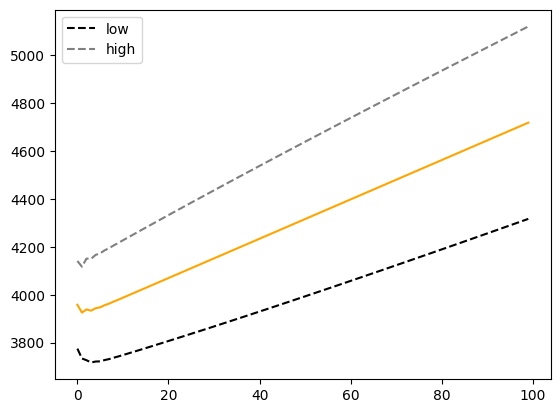

In [ ]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='black', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend();

# Check for seasonality

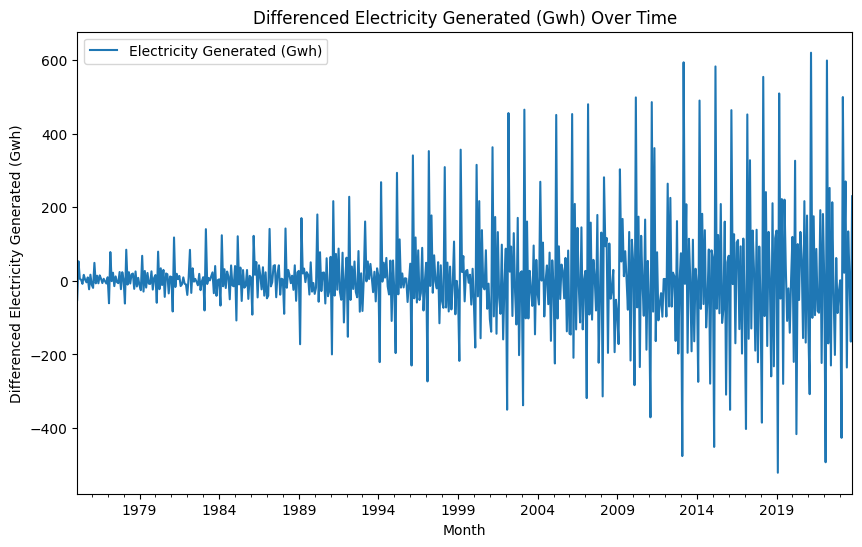

In [213]:
df2 = df1.copy()
df2['Month'] = pd.to_datetime(df2['Month'])

# Set "Month" column as index
df2.set_index('Month', inplace=True)

# Difference the time series data
df2_diff1 = df2.diff().dropna()  # Compute difference and drop missing values (first row)

# Plot the differenced time series
df2_diff1.plot(figsize=(10, 6))
plt.title('Differenced Electricity Generated (Gwh) Over Time')
plt.xlabel('Month')
plt.ylabel('Differenced Electricity Generated (Gwh)')
plt.show()

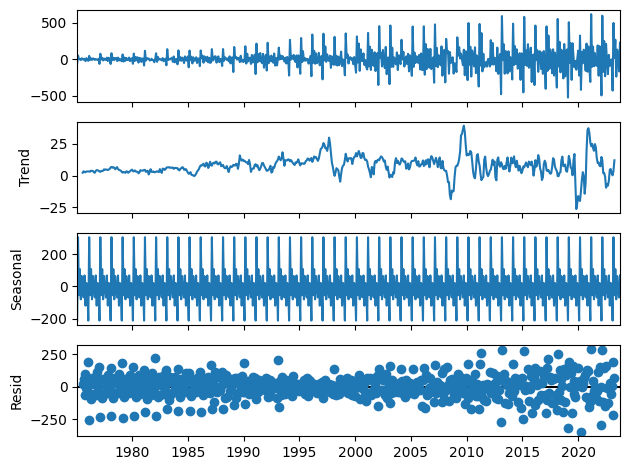

In [214]:
# Decompose the time series
# Ensure you're working with a series without NaNs or handle NaNs as per your requirement.
decomposition = seasonal_decompose(df2_diff1, model='additive')
decomposition.plot()
plt.show()

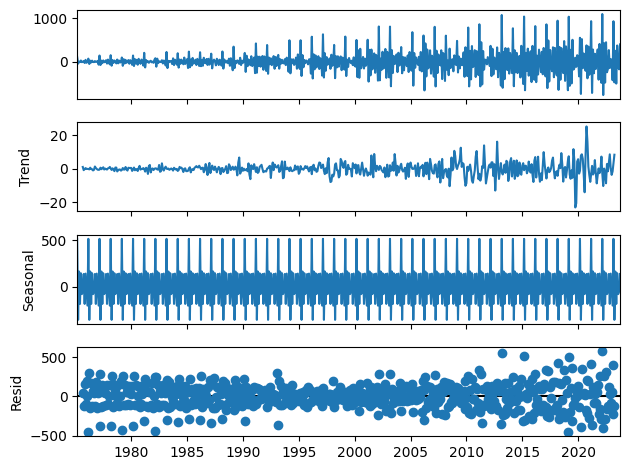

In [139]:
df2_diff2 = df2_diff1.diff().dropna()  # Compute difference and drop missing values (first row)
decomposition = seasonal_decompose(df2_diff2, model='additive')
decomposition.plot()
plt.show()

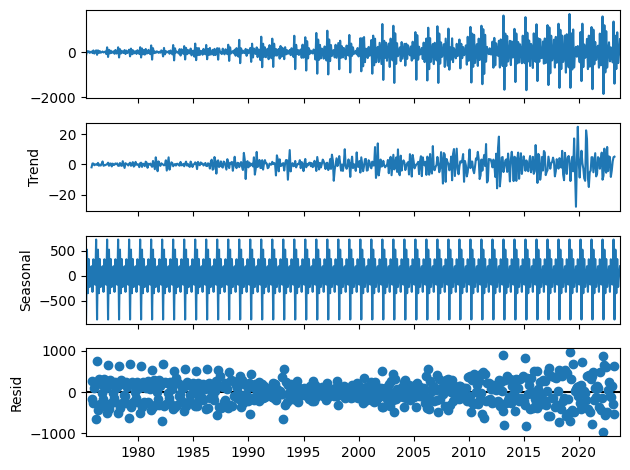

In [215]:
df2_diff3 = df2_diff2.diff().dropna()  # Compute difference and drop missing values (first row)
decomposition = seasonal_decompose(df2_diff3, model='additive')
decomposition.plot()
plt.show()

Text(0.5, 1.0, 'third difference')

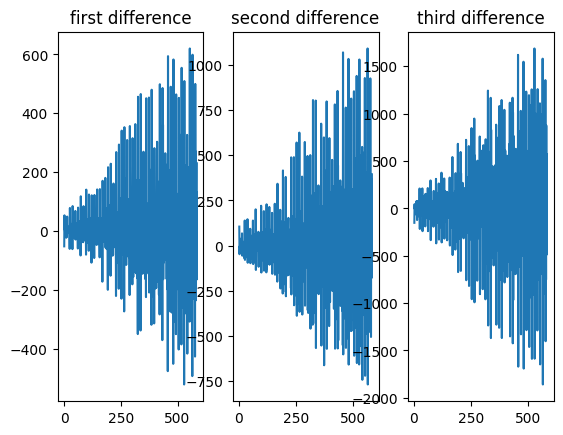

In [115]:
plt.subplot(1,3,1)
# non_differenced_data = pd.Series(y)
yd1 = y.diff().dropna()
yd1.plot();
plt.title('first difference')

plt.subplot(1,3,2)
yd2 = yd1.diff().dropna()
yd2.plot()
plt.title('second difference')

plt.subplot(1,3,3)
yd3 = yd2.diff().dropna()
yd3.plot()
plt.title('third difference')

**The current ARIMA model (3,1,1) still has seasonality component (even up till d=3), i.e. not fully stationary. **

👉 **solution: SARIMA model**

#SARIMA

In [88]:
import pmdarima as pm
smodel = pm.auto_arima(y_train,
                       start_p=0, max_p=2,
                       start_d=0, max_d=1,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_D=0, max_D=2,
                       start_Q=0, max_Q=2,
                       stepwise=True,
                       test='adf',
                       suppress_warnings=True,
                       seasonal=True,
                       m=12,
                       trace=True,
                       njobs=-1,
                       error_action='ignore')

# model = pm.auto_arima(
#     y_train,
#     m=12, # frequency of series. Important to choose manually
#     seasonal=True,
#     stepwise=True,  # only check the most interesting combination. False will take way longer.
#     start_p=0, max_p=2,
#     start_d=0, max_d=1,
#     start_q=0, max_q=2,
#     start_P=0, max_P=2,
#     start_D=0, max_D=2,
#     start_Q=0, max_Q=2,
#     njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True
# )

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6299.275, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5562.845, Time=2.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5860.372, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6299.214, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6111.320, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=5361.366, Time=4.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=5856.107, Time=1.26 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=5355.930, Time=6.66 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=13.52 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=5353.799, Time=6.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=5745.696, Time=2.60 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=5484.995, Time=3.69 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=5318.994, Time=7.04 sec
 ARIMA(2,1,0)(0,0,2)[12] int

***Optimal SARIMAX parameters: p=2, d=1, q=0, P=1, D=0, Q=2, m=12***

In [216]:
# Forecast y_test
n_periods = len(y_test)
central, conf_int = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = y_test.index #pd.date_range(y_test.index[-1], periods = n_periods, freq='MS')

# Make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(conf_int[:, 0], index=index_y_test)
upper = pd.Series(conf_int[:, 1], index=index_y_test)

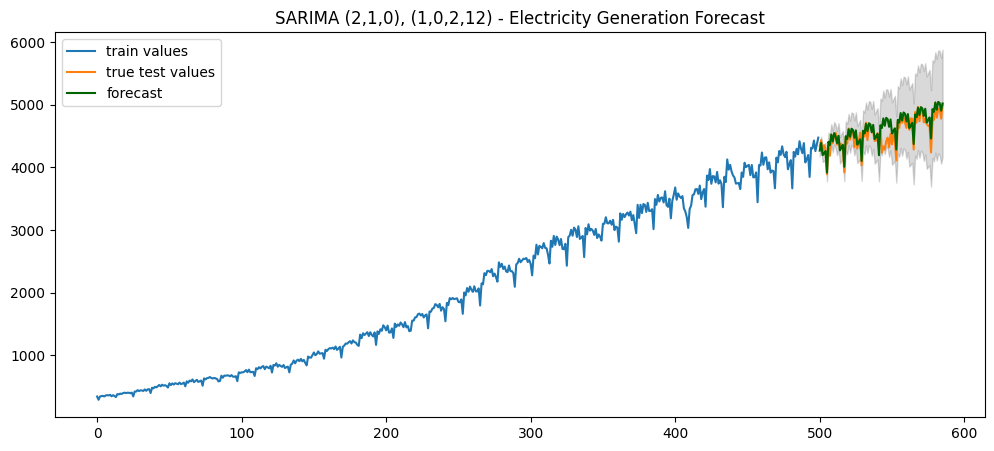

In [217]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color='k', alpha=.15
)

plt.title('SARIMA (2,1,0), (1,0,2,12) - Electricity Generation Forecast')
plt.legend()
plt.show()

In [218]:
forecast_accuracy(central, y_test)

{'mape': 0.020855073354338248,
 'me': 69.42471560321137,
 'mae': 93.11455418650016,
 'mpe': 0.015588773222638238,
 'rmse': 132.07244016692349,
 'acf1': 0.6435789961288475,
 'corr': 0.8917268493812157,
 'minmax': 0.020056685414594377}

2% MAPE implies the model is about 98% accurate in predicting the next  86 observations.

In [149]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(y_train, order=(2, 1, 0), seasonal_order=(1, 0, 2, 12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


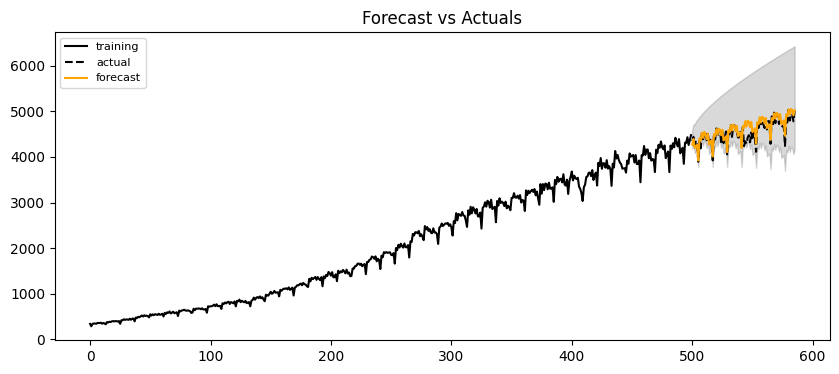

In [219]:
# Forecast values and confidence intervals
forecast_S_results = sarima.get_forecast(len(y_test), alpha=0.05) #95%cf
forecast_S = forecast_S_results.predicted_mean
confidence_int_S = forecast_S_results.conf_int().values
plot_forecast(forecast_S, y_train, y_test, confidence_int_S[:,0], confidence_int[:,1])

In [151]:
forecast_accuracy(forecast_S, y_test)

{'mape': 0.020855073354338248,
 'me': 69.42471560321137,
 'mae': 93.11455418650016,
 'mpe': 0.015588773222638238,
 'rmse': 132.07244016692349,
 'acf1': 0.6435789961288475,
 'corr': 0.8917268493812157,
 'minmax': 0.020056685414594377}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


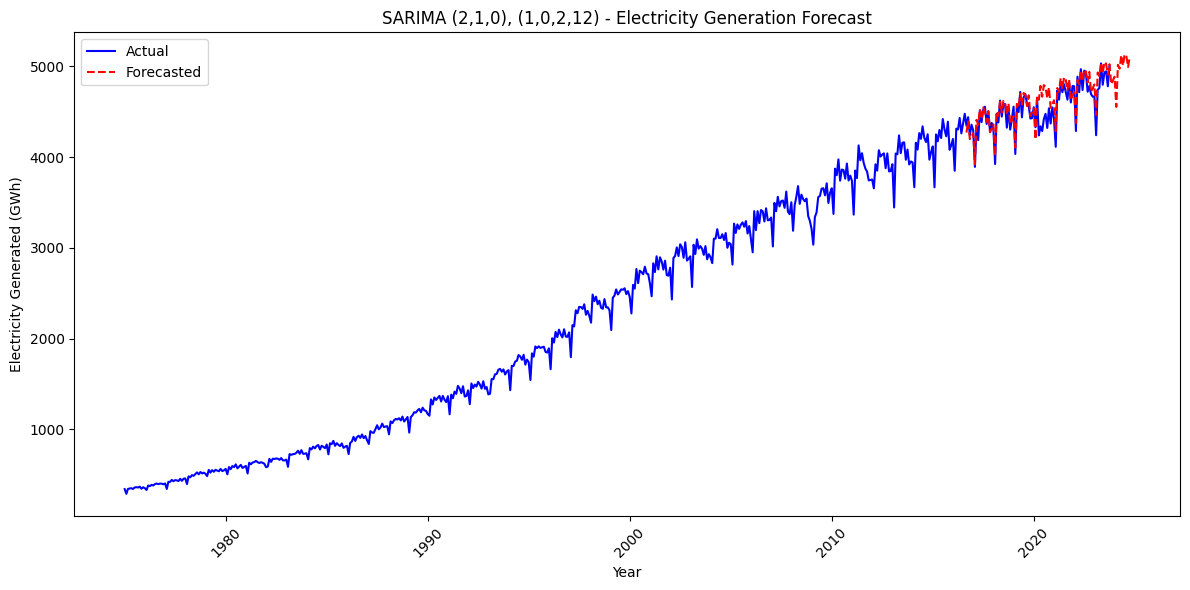

In [195]:
# Forecast additional 12 points after y_test
n_additional_periods = 98   #last 86 rows (test size) + 12 months after Oct 2023
forecast_results_S_12m = sarima.get_forecast(steps=n_additional_periods, alpha=0.05)  #cf=95%
forecast_S_12m = forecast_results_S_12m.predicted_mean
conf_int_S_12m = forecast_results_S_12m.conf_int()

# Creating a DataFrame for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-87] + pd.offsets.MonthBegin(1), periods=len(forecast_S_12m), freq='MS') #'M': start of month, 'MS': end of month
forecast_S_12m_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_S_12m.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(forecast_S_12m_df['Month'], forecast_S_12m_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='--')
plt.title('SARIMA (2,1,0), (1,0,2,12) - Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()



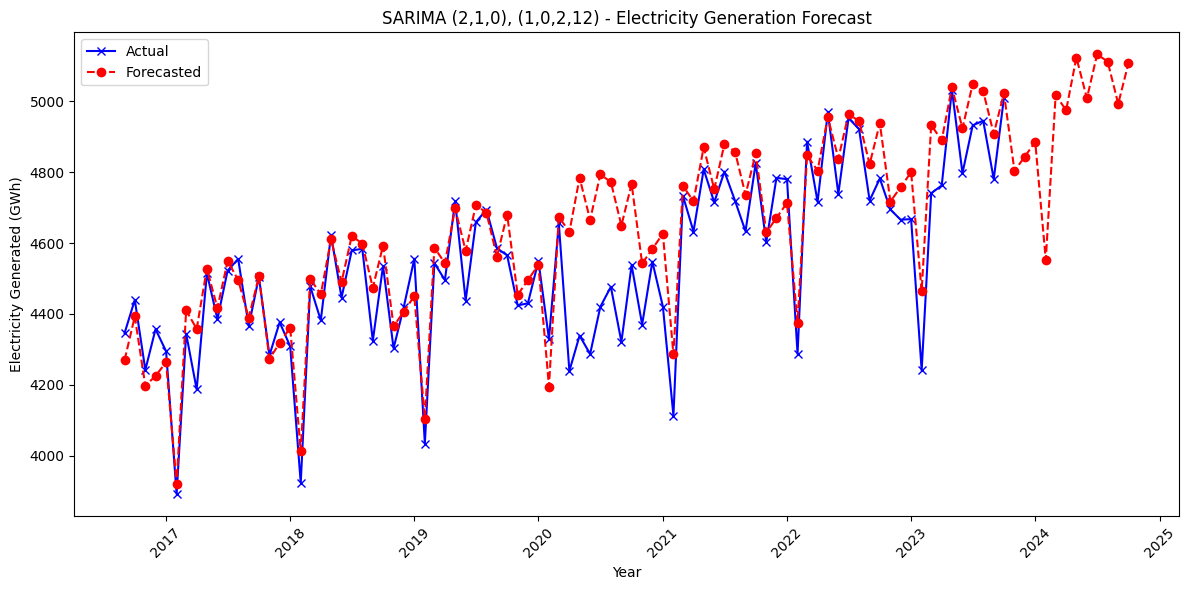

In [196]:
# Creating a DataFrame for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-87] + pd.offsets.MonthBegin(1), periods=len(forecast_S_12m), freq='MS') #'M': start of month, 'MS': end of month
forecast_S_12m_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_S_12m.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
#plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(df1['Month'].iloc[-86:], df1['Electricity Generated (Gwh)'].iloc[-86:], label='Actual', color='blue', marker='x')
plt.plot(forecast_S_12m_df['Month'], forecast_S_12m_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='--', marker='o')
plt.title('SARIMA (2,1,0), (1,0,2,12) - Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [198]:
forecast_S_12m_df.tail(12)

,Month,Forecasted Electricity Generated (Gwh)
86,2023-11-01,4803.315322
87,2023-12-01,4843.562541
88,2024-01-01,4885.347099
89,2024-02-01,4552.566411
90,2024-03-01,5017.074755
91,2024-04-01,4974.892056
92,2024-05-01,5123.443651
93,2024-06-01,5008.311015
94,2024-07-01,5132.451062
95,2024-08-01,5111.968729
